In [1]:
import sys
sys.path.append("/home/zhhu/workspaces/deepinv/")

In [2]:
from datetime import datetime
import deepinv as dinv
from pathlib import Path
from time import time
import math

import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
from deepinv.models import DRUNet
from deepinv.optim.data_fidelity import L2
from deepinv.optim.prior import PnP
from deepinv.optim.optimizers import optim_builder
from deepinv.utils.demo import load_url_image, get_image_url
from deepinv.utils.plotting import plot, plot_curves
from deepinv.optim.phase_retrieval import correct_global_phase, cosine_similarity, spectral_methods, default_preprocessing, spectral_methods_wrapper
from deepinv.models.complex import to_complex_denoiser

In [3]:
device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"
device

Selected GPU 1 with 32497 MB free memory 


device(type='cuda', index=1)

# Compare the forward time for random and pseudorandom model

In [30]:
n_repeats = 100
oversampling = 9

torch.Size([1, 1, 99, 99])


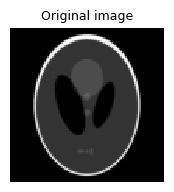

In [6]:
# Load image
img_size = 99
url = get_image_url("SheppLogan.png")
x = load_url_image(
    url=url, img_size=img_size, grayscale=True, resize_mode="resize", device=device
)
print(x.shape)
plot(x, titles="Original image")

# generate phase signal

# The phase is computed as 2*pi*x - pi, where x is the original image.
x_phase = torch.exp(1j*x*torch.pi - 0.5j*torch.pi).to(device)

# Every element of the signal should have unit norm.
assert torch.allclose(x_phase.real**2 + x_phase.imag**2, torch.tensor(1.0))

In [33]:
# random model

res_random_cpu = torch.empty(n_repeats)
res_random_gpu = torch.empty(n_repeats)

torch.cuda.synchronize()
x_phase_cpu = x_phase.cpu()
for i in trange(n_repeats):
    physics = dinv.physics.RandomPhaseRetrieval(
        m = int(oversampling*torch.prod(torch.tensor(x.shape))),
        img_shape= (1, img_size, img_size),
        dtype = torch.cfloat,
        device='cpu',
    )
    init_time = time()
    y = physics.forward(x_phase_cpu)
    res_random_cpu[i] = time() - init_time

torch.cuda.synchronize()
for i in trange(n_repeats):
    physics = dinv.physics.RandomPhaseRetrieval(
        m = int(oversampling*torch.prod(torch.tensor(x.shape))),
        img_shape= (1, img_size, img_size),
        dtype = torch.cfloat,
        device=device,
    )
    torch.cuda.synchronize()
    init_time = time()
    y = physics.forward(x_phase)
    torch.cuda.synchronize() 
    res_random_gpu[i] = time() - init_time

print(f"Forward time (random)(CPU): {res_random_cpu.mean():.4f} s")
print(f"Forward time (random)(GPU): {res_random_gpu.mean():.4f} s")

100%|██████████| 100/100 [00:05<00:00, 18.70it/s]

Forward time (random)(CPU): 0.0510 s
Forward time (random)(GPU): 0.0082 s


In [37]:
# pseudorandom model

res_pseudorandom_cpu = torch.empty(n_repeats)
res_pseudorandom_gpu = torch.empty(n_repeats)

torch.cuda.synchronize()
x_phase_cpu = x_phase.cpu()
for i in trange(n_repeats):
    physics = dinv.physics.PseudoRandomPhaseRetrieval(
        n_layers=2,
        input_shape=(1, img_size, img_size),
        output_shape=(1, int(math.sqrt(oversampling))*img_size, int(math.sqrt(oversampling))*img_size),
        dtype = torch.cfloat,
        device='cpu',
    )
    init_time = time()
    y = physics.forward(x_phase_cpu)
    res_random_cpu[i] = time() - init_time

torch.cuda.synchronize()
for i in trange(n_repeats):
    physics = dinv.physics.PseudoRandomPhaseRetrieval(
        n_layers=2,
        input_shape=(1, img_size, img_size),
        output_shape=(1, int(math.sqrt(oversampling))*img_size, int(math.sqrt(oversampling))*img_size),
        dtype = torch.cfloat,
        device=device,
    )
    torch.cuda.synchronize()
    init_time = time()
    y = physics.forward(x_phase)
    torch.cuda.synchronize() 
    res_random_gpu[i] = time() - init_time

print(f"Forward time (pseudorandom)(CPU): {res_random_cpu.mean():.4f} s")
print(f"Forward time (pseudorandom)(GPU): {res_random_gpu.mean():.4f} s")

100%|██████████| 100/100 [00:00<00:00, 1614.93it/s]

Forward time (random)(CPU): 0.0037 s
Forward time (random)(GPU): 0.0003 s


# Forward time w.r.t. image size

In [63]:
max_size = 501
n_repeats = 100
oversampling = 1

img_sizes = torch.arange(1, max_size, 2)

In [ ]:
# random model
res_random = torch.empty(len(img_sizes), n_repeats)

for img_size in tqdm(img_sizes):
    img_size = img_size.item()
    x = load_url_image(url=url, img_size=img_size, grayscale=True, resize_mode="resize", device=device)
    x_phase = torch.exp(1j*x*torch.pi - 0.5j*torch.pi).to(device)

    torch.cuda.synchronize()
    for i in range(n_repeats):
        physics = dinv.physics.RandomPhaseRetrieval(
            m = int(oversampling*torch.prod(torch.tensor(x.shape))),
            img_shape= (1, img_size, img_size),
            dtype = torch.cfloat,
            device=device,
        )
        torch.cuda.synchronize()
        init_time = time()
        y = physics.forward(x_phase)
        torch.cuda.synchronize() 
        res_random[(img_size-1)//2,i] = time() - init_time

In [65]:
res_pseudorandom = torch.empty(len(img_sizes), n_repeats)

# pseudorandom model
for img_size in tqdm(img_sizes):
    img_size = img_size.item()
    x = load_url_image(url=url, img_size=img_size, grayscale=True, resize_mode="resize", device=device)
    x_phase = torch.exp(1j*x*torch.pi - 0.5j*torch.pi).to(device)

    torch.cuda.synchronize()
    for i in range(n_repeats):
        physics = dinv.physics.PseudoRandomPhaseRetrieval(
            n_layers=2,
            input_shape=(1, img_size, img_size),
            output_shape=(1, int(math.sqrt(oversampling))*img_size, int(math.sqrt(oversampling))*img_size),
            dtype = torch.cfloat,
            device=device,
        )
        torch.cuda.synchronize()
        init_time = time()
        y = physics.forward(x_phase)
        torch.cuda.synchronize() 
        res_pseudorandom[(img_size-1)//2,i] = time() - init_time

100%|██████████| 250/250 [01:07<00:00,  3.71it/s]


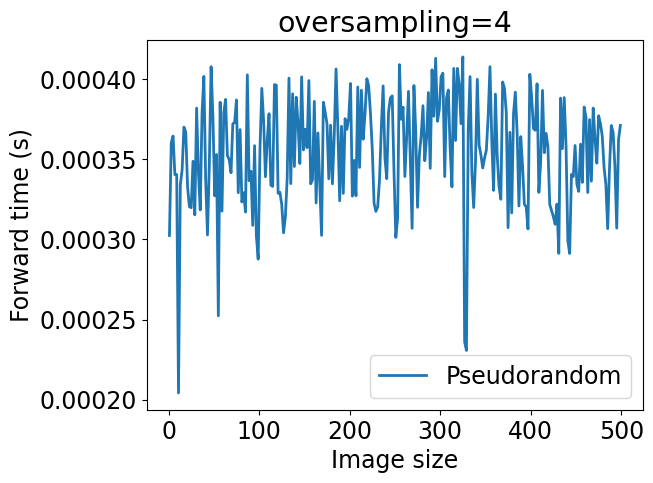

In [66]:
#plt.plot(img_sizes,(res_random.mean(dim=1)).numpy(),label='Random')
plt.plot(img_sizes,(res_pseudorandom.mean(dim=1)).numpy(),label='Pseudorandom')
plt.xlabel('Image size')
plt.ylabel('Forward time (s)')
#plt.yscale('log')
plt.title('oversampling=4')
plt.legend()
plt.show()

# Use deepinv optimizer for random model

In [73]:
# Set up the variable to fetch dataset and operators.
img_size = 99
url = get_image_url("SheppLogan.png")
x = load_url_image(
    url=url, img_size=img_size, grayscale=True, resize_mode="resize", device=device
)
x.shape

# generate phase signal

# The phase is computed as 2*pi*x - pi, where x is the original image.
x_phase = torch.exp(1j * x * torch.pi - 0.5j * torch.pi).to(device)

# Every element of the signal should have unit norm.
assert torch.allclose(x_phase.real**2 + x_phase.imag**2, torch.tensor(1.0))

In [95]:
data_fidelity = L2()
prior = dinv.optim.prior.Zero()
max_iter = 5000
early_stop = True
verbose = True
# stepsize: use 1e-4 for oversampling ratio 0-2, and 3e-3*oversampling for oversampling ratio 2-9
step_size = 5e-3

In [96]:
physics = dinv.physics.RandomPhaseRetrieval(
    m=3*torch.prod(torch.tensor(x.shape)),
    img_shape=(1, img_size, img_size),
    dtype=torch.cfloat,
    device=device,
)
y = physics(x_phase)

In [97]:
params_algo = {"stepsize": step_size * 3, "g_params": 0.00}
print("stepsize:", params_algo["stepsize"])
model = optim_builder(
    iteration="PGD",
    prior=prior,
    data_fidelity=data_fidelity,
    early_stop=early_stop,
    max_iter=max_iter,
    verbose=verbose,
    params_algo=params_algo,
    custom_init=spectral_methods_wrapper,
)

x_phase_gd_spec, _ = model(y, physics, x_gt=x_phase, compute_metrics=True)

stepsize: 0.015


Image 0, channel 0 does not have a global phase shift.
Cosine similarity: 0.9884


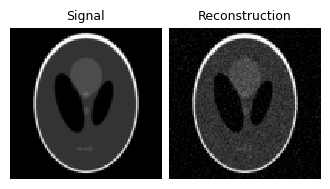

In [98]:
x_phase_gd_spec = correct_global_phase(x_phase_gd_spec, x_phase)
metrics = cosine_similarity(x_phase_gd_spec, x_phase)
print(f"Cosine similarity: {metrics:.4f}")
# extract phase information and normalize to the range [0, 1]
x_gd_spec = torch.angle(x_phase_gd_spec) / torch.pi + 0.5
plot([x, x_gd_spec],titles=["Signal","Reconstruction"],rescale_mode='clip')

# Use PnP as regularizer

In [17]:
# Set up the variable to fetch dataset and operators.
img_size = 99
url = get_image_url("SheppLogan.png")
x = load_url_image(
    url=url, img_size=img_size, grayscale=True, resize_mode="resize", device=device
)
x.shape

# generate phase signal

# The phase is computed as 2*pi*x - pi, where x is the original image.
x_phase = torch.exp(1j * x * torch.pi - 0.5j * torch.pi).to(device)

# Every element of the signal should have unit norm.
assert torch.allclose(x_phase.real**2 + x_phase.imag**2, torch.tensor(1.0))

In [36]:
noise_level_img = 0.05

physics = dinv.physics.PseudoRandomPhaseRetrieval(
    n_layers=2,
    input_shape=(1, img_size, img_size),
    output_shape=(1, 171, 171),
    dtype=torch.cfloat,
    device=device,
    #noise_model=dinv.physics.GaussianNoise(sigma=noise_level_img)
)
y = physics(x_phase)

In [37]:
n_channels = 1

denoiser = DRUNet(
    in_channels=n_channels,
    out_channels=n_channels,
    pretrained="download",  # automatically downloads the pretrained weights, set to a path to use custom weights.
    train=False,
    device=device,
) # TODO: use dncnn lipschitz constant
denoiser_complex = to_complex_denoiser(denoiser,mode="abs_angle")

In [48]:
data_fidelity = L2()
prior = dinv.optim.prior.PnP(denoiser=denoiser_complex)
#prior = dinv.optim.prior.Zero()
max_iter = 5000
early_stop = True
verbose = True
# stepsize: use 1e-4 for oversampling ratio 0-2, and 3e-3*oversampling for oversampling ratio 2-9
step_size = 1e-5

In [49]:
params_algo = {"stepsize": step_size, "g_param": 0.10}
print("stepsize:", params_algo["stepsize"])
model = optim_builder(
    iteration="PGD",
    prior=prior,
    data_fidelity=data_fidelity,
    early_stop=early_stop,
    max_iter=max_iter,
    verbose=verbose,
    params_algo=params_algo,
    custom_init=spectral_methods_wrapper,
)

x_phase_gd_spec = model(y, physics, x_gt=x_phase, compute_metrics=True)

stepsize: 1e-05


Image 0, channel 0 does not have a global phase shift.


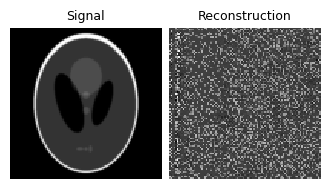

Cosine similarity: 0.1567


In [50]:
# correct possible global phase shifts
x_gd_spec = correct_global_phase(x_phase_gd_spec, x_phase)
# now no global phase shift should exist
#assert torch.allclose(x_est, x_phase)
# extract phase information and normalize to the range [0, 1]
x_gd_spec = torch.angle(x_gd_spec) / (2*torch.pi) + 0.5
plot([x, x_gd_spec],titles=["Signal","Reconstruction"],rescale_mode='clip')
print(f"Cosine similarity: {cosine_similarity(x_phase_gd_spec, x_phase):.4f}")

# Use shared weights

In [63]:
# Set up the variable to fetch dataset and operators.
img_size = 99
url = get_image_url("SheppLogan.png")
x = load_url_image(
    url=url, img_size=img_size, grayscale=True, resize_mode="resize", device=device
)
x.shape

# generate phase signal

# The phase is computed as 2*pi*x - pi, where x is the original image.
x_phase = torch.exp(1j * x * torch.pi - 0.5j * torch.pi).to(device)

# Every element of the signal should have unit norm.
assert torch.allclose(x_phase.real**2 + x_phase.imag**2, torch.tensor(1.0))

In [115]:
physics = dinv.physics.PseudoRandomPhaseRetrieval(
    n_layers=2,
    input_shape=(1, img_size, img_size),
    output_shape=(1, 171, 171),
    dtype=torch.cfloat,
    device=device,
    drop_tail=True,
)

y = physics(x_phase)

In [116]:
physics.diagonals

[tensor([[[ 0.9043+0.4269j, -0.9371+0.3490j,  0.9860-0.1670j,  ...,
            0.8112-0.5847j, -0.4085-0.9127j, -0.2068-0.9784j],
          [-0.8704-0.4924j,  0.2522+0.9677j,  0.7762+0.6305j,  ...,
           -0.9692-0.2462j,  0.1771+0.9842j,  0.0209+0.9998j],
          [ 0.4133-0.9106j,  0.8790-0.4768j, -0.0561+0.9984j,  ...,
           -0.9329-0.3601j, -0.7650-0.6441j,  0.2472+0.9690j],
          ...,
          [-0.7214+0.6925j,  1.0000-0.0056j, -0.7232-0.6906j,  ...,
           -0.4729+0.8811j,  0.2255+0.9742j, -0.2785+0.9604j],
          [ 0.9791-0.2032j, -0.3175-0.9483j,  0.1280+0.9918j,  ...,
            0.8135+0.5816j, -0.8794+0.4761j,  0.9640-0.2660j],
          [ 0.0550+0.9985j,  0.9712+0.2381j,  0.2819+0.9594j,  ...,
           -0.9376-0.3478j, -0.6433+0.7656j,  0.8973+0.4414j]]],
        device='cuda:0'),
 tensor([[[ 0.9389+0.3442j, -0.8902+0.4556j,  0.2784-0.9605j,  ...,
           -0.1529+0.9882j,  0.7776+0.6288j, -0.8758+0.4826j],
          [ 0.3117+0.9502j, -0.3825-0.92

In [117]:
assert torch.allclose((physics.B.A_adjoint(physics.B(x_phase))),x_phase)

In [118]:
data_fidelity = L2()
#prior = dinv.optim.prior.PnP(denoiser=denoiser_complex)
prior = dinv.optim.prior.Zero()
max_iter = 10000
early_stop = True
verbose = True
# stepsize: use 1e-4 for oversampling ratio 0-2, and 3e-3*oversampling for oversampling ratio 2-9
step_size = 1e-2

In [119]:
def spectral_methods_wrapper(y, physics, n_iter=5000, **kwargs):
    x = spectral_methods(y, physics, n_iter=n_iter, **kwargs)
    z = spectral_methods(y, physics, n_iter=n_iter, **kwargs)
    return {"est": (x, z)}

In [122]:
params_algo = {"stepsize": step_size, "g_param": 0.00}
print("stepsize:", params_algo["stepsize"])
model = optim_builder(
    iteration="PGD",
    prior=prior,
    data_fidelity=data_fidelity,
    early_stop=early_stop,
    max_iter=max_iter,
    verbose=verbose,
    params_algo=params_algo,
    custom_init=spectral_methods_wrapper,
)

x_phase_gd_spec = model(y, physics, x_gt=x_phase)

stepsize: 0.01


Image 0, channel 0 does not have a global phase shift.


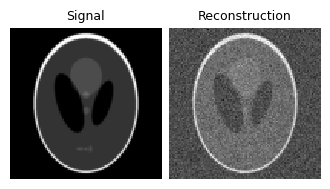

Cosine similarity: 0.9506


In [123]:
# correct possible global phase shifts
x_gd_spec = correct_global_phase(x_phase_gd_spec, x_phase)
# now no global phase shift should exist
#assert torch.allclose(x_est, x_phase)
# extract phase information and normalize to the range [0, 1]
x_gd_spec = torch.angle(x_gd_spec) / (2*torch.pi) + 0.5
plot([x, x_gd_spec],titles=["Signal","Reconstruction"],rescale_mode='clip')
print(f"Cosine similarity: {cosine_similarity(x_phase_gd_spec, x_phase):.4f}")

# Try QR decomposition

In [4]:
A = torch.randn((5,3),dtype=torch.cfloat,device=device)
print(A)

tensor([[-0.8743+0.3645j, -0.7821-0.3355j,  0.4701-0.8829j],
        [ 0.4294-1.0614j, -0.3441+0.9698j,  0.0404+1.7377j],
        [-0.2848+0.1911j, -0.6175-0.1912j,  0.0704+0.0362j],
        [-1.1079-0.6402j,  0.1408+0.3108j, -1.6640-0.0430j],
        [ 0.2608+0.4154j,  0.3932+1.1281j,  0.0477+0.4164j]], device='cuda:0')


In [5]:
Q, R = torch.linalg.qr(A)
print(Q.shape)
print(R.shape)
print(Q@R)

torch.Size([5, 3])
torch.Size([3, 3])
tensor([[-0.8743+0.3645j, -0.7821-0.3355j,  0.4701-0.8829j],
        [ 0.4294-1.0614j, -0.3441+0.9698j,  0.0404+1.7377j],
        [-0.2848+0.1911j, -0.6175-0.1912j,  0.0704+0.0362j],
        [-1.1079-0.6402j,  0.1408+0.3108j, -1.6640-0.0430j],
        [ 0.2608+0.4154j,  0.3932+1.1281j,  0.0477+0.4164j]], device='cuda:0')


In [6]:
Q@R-A

tensor([[-1.7881e-07+0.0000e+00j,  0.0000e+00+2.9802e-08j,
          1.1921e-07-3.5763e-07j],
        [ 2.9802e-08+0.0000e+00j, -5.9605e-08+5.9605e-08j,
          1.0803e-07-1.1921e-07j],
        [ 0.0000e+00-1.4901e-08j,  0.0000e+00+1.4901e-08j,
          2.9802e-08-5.5879e-08j],
        [-1.1921e-07-5.9605e-08j,  1.4901e-08-2.9802e-08j,
          0.0000e+00-8.5682e-08j],
        [ 0.0000e+00+0.0000e+00j,  5.9605e-08+1.1921e-07j,
         -1.1921e-07-2.9802e-08j]], device='cuda:0')

In [7]:
print(torch.diag(R))
print(torch.sgn(torch.diag(R)))
print(torch.diag(torch.sgn(torch.diag(R))))

tensor([ 2.0503+0.j,  1.9024+0.j, -2.4322+0.j], device='cuda:0')
tensor([ 1.+0.j,  1.+0.j, -1.+0.j], device='cuda:0')
tensor([[ 1.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j,  1.+0.j,  0.+0.j],
        [ 0.+0.j,  0.+0.j, -1.+0.j]], device='cuda:0')


In [8]:
B = torch.arange(1,10).reshape(3,3).to(device).to(torch.cfloat)
print(B)
print(B*torch.sgn(torch.diag(R))[None,:])

tensor([[1.+0.j, 2.+0.j, 3.+0.j],
        [4.+0.j, 5.+0.j, 6.+0.j],
        [7.+0.j, 8.+0.j, 9.+0.j]], device='cuda:0')
tensor([[ 1.+0.j,  2.+0.j, -3.+0.j],
        [ 4.+0.j,  5.+0.j, -6.+0.j],
        [ 7.+0.j,  8.+0.j, -9.+0.j]], device='cuda:0')


# Try Haar matrix

In [4]:
# Set up the variable to fetch dataset and operators.
img_size = 99
url = get_image_url("SheppLogan.png")
x = load_url_image(
    url=url, img_size=img_size, grayscale=True, resize_mode="resize", device=device
)
x.shape

# generate phase signal

# The phase is computed as 2*pi*x - pi, where x is the original image.
x_phase = torch.exp(1j * x * torch.pi - 0.5j * torch.pi).to(device)

# Every element of the signal should have unit norm.
assert torch.allclose(x_phase.real**2 + x_phase.imag**2, torch.tensor(1.0))

In [5]:
physics = dinv.physics.RandomPhaseRetrieval(
    m=3*torch.prod(torch.tensor(x.shape)),
    img_shape=(1, img_size, img_size),
    dtype=torch.cfloat,
    device=device,
    use_haar=True,
)

y = physics(x_phase)

Using Haar matrix


In [6]:
assert torch.allclose((physics.B.A_adjoint(physics.B(x_phase))),x_phase)

In [7]:
data_fidelity = L2()
#prior = dinv.optim.prior.PnP(denoiser=denoiser_complex)
prior = dinv.optim.prior.Zero()
max_iter = 10000
early_stop = True
verbose = True
# stepsize: use 1e-4 for oversampling ratio 0-2, and 3e-3*oversampling for oversampling ratio 2-9
step_size = 1e-2

In [8]:
def spectral_methods_wrapper(y, physics, n_iter=5000, **kwargs):
    x = spectral_methods(y, physics, n_iter=n_iter, **kwargs)
    z = spectral_methods(y, physics, n_iter=n_iter, **kwargs)
    return {"est": (x, z)}

In [9]:
params_algo = {"stepsize": step_size, "g_param": 0.00}
print("stepsize:", params_algo["stepsize"])
model = optim_builder(
    iteration="PGD",
    prior=prior,
    data_fidelity=data_fidelity,
    early_stop=early_stop,
    max_iter=max_iter,
    verbose=verbose,
    params_algo=params_algo,
    custom_init=spectral_methods_wrapper,
)

x_phase_gd_spec = model(y, physics, x_gt=x_phase)

stepsize: 0.01


Image 0, channel 0 does not have a global phase shift.


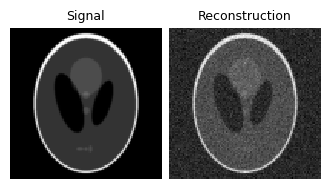

Cosine similarity: 0.9745


In [10]:
# correct possible global phase shifts
x_gd_spec = correct_global_phase(x_phase_gd_spec, x_phase)
# now no global phase shift should exist
#assert torch.allclose(x_est, x_phase)
# extract phase information and normalize to the range [0, 1]
x_gd_spec = torch.angle(x_gd_spec) / (2*torch.pi) + 0.5
plot([x, x_gd_spec],titles=["Signal","Reconstruction"],rescale_mode='clip')
print(f"Cosine similarity: {cosine_similarity(x_phase_gd_spec, x_phase):.4f}")